In [1]:
# pip install xgboost
# pip install hyperopt
#https://hyperopt.github.io/hyperopt/?source=post_page
# pip install category_encoders
# pip install scikit-optimize
# pip install dtreeviz


**Install Libraries**

In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


import shap

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting


import dtreeviz
import graphviz



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder



# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler




**Load datasets**

In [3]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [4]:
df_bb= load_dataset('cleaned_files/basketball_clean_supervised.csv')
df_fb= load_dataset('cleaned_files/football_clean_supervised.csv')

In [5]:
df_fb.head(3)

,Unnamed: 0,NAME,GRADE,AGE,SKILL,STARCOLL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,...,TIK_LONG,TOT_FOL,SPORT,RECRUIT_YEAR,EXP_MONTHS,EXP_YEARS,institution_name_short,ClassificationCode,REV_MEN,EXP_MEN
0,0,Arch Manning,2.0,18.28281,99.53,Texas,18.0,1.0,75.5,220.0,...,8900.0,73900.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0
1,1,Anthony Hill,2.0,18.00000,97.87,Texas,25.0,8.0,73.5,225.0,...,0.0,13100.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0
2,2,CJ Baxter Jr.,2.0,18.00000,97.26,Texas,25.0,9.0,73.0,216.0,...,1700.0,10900.0,football,2023.0,2.0,0.189041,Texas,1.0,161532860.0,50633156.0


In [6]:
#save athlete names for later indexing
athletes_fb = df_fb['NAME']
athletes_bb = df_bb['NAME']
# athlete_names

df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT','STARCOLL','EXP_YEARS','institution_name_short'])
df_fb= df_fb.drop(columns=['Unnamed: 0', 'NAME','SPORT', 'STARCOLL','EXP_YEARS','institution_name_short'])


In [7]:

df_fb.columns
# df_fb.info()

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [8]:
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

**Standard Train Test Split**

In [9]:

def split_data(df, train_size_=0.70, valid_size_=0.15, test_size_=0.15, random_state=42):
    # Log-transform y
    df=df.copy()
    y = df.pop("NILVAL_LONG_USD")
    # y = np.log1p(y)
    X = df
    

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=valid_size_ + test_size_, 
    shuffle = True, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_size_ / (valid_size_ + test_size_), shuffle = True, random_state=random_state)

    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_valid = pd.DataFrame(X_valid, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [10]:
X_train_bb, y_train_bb, X_valid_bb, y_valid_bb, X_test_bb, y_test_bb = split_data(df_bb)
X_train_fb, y_train_fb, X_valid_fb, y_valid_fb, X_test_fb, y_test_fb = split_data(df_fb)

print((X_train_bb.shape,y_train_bb.shape ),(X_valid_bb.shape, y_valid_bb.shape),(X_test_bb.shape, y_test_bb.shape))
print((X_train_fb.shape,y_train_fb.shape ),(X_valid_fb.shape, y_valid_fb.shape),(X_test_fb.shape, y_test_fb.shape))

((95, 17), (95,)) ((21, 17), (21,)) ((21, 17), (21,))
((884, 17), (884,)) ((189, 17), (189,)) ((190, 17), (190,))


In [11]:
from sklearn.model_selection import KFold

def train_xgboost_with_cv_and_analysis(X_train, y_train, X_test, y_test, params, num_boost_round, early_stopping_rounds):
    # Define the number of folds for cross-validation
    n_folds = 5  # You can adjust this as needed
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize XGBoost model with the given parameters
    model = xgb.XGBRegressor(**params)
    
    # Create a list to store cross-validation scores
    cv_scores = []
    
    # Create a list to store feature importances
    feature_importances = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        DM_train = xgb.DMatrix(data=X_train_fold, label=y_train_fold, enable_categorical=True)
        DM_val = xgb.DMatrix(data=X_val_fold, label=y_val_fold, enable_categorical=True)
        
        # Train the model with early stopping
        eval_results = {}
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric=params["eval_metric"],
            early_stopping_rounds=early_stopping_rounds,
            # verbosity=params["verbosity"],
        )
        
        # Get the best iteration
        best_iteration = model.best_iteration
        
        # Make predictions on the test set
        y_pred = model.predict(X_test, ntree_limit=best_iteration)
        
        # Calculate the RMSE for this fold
        fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        cv_scores.append(fold_rmse)
        
        # Explain the model's predictions using SHAP
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X_test)
        
        # Calculate and store feature importances for this fold
        fold_feature_importances = np.abs(shap_values).mean(axis=0)
        feature_importances.append(fold_feature_importances)
    
    # Calculate the average feature importance across all folds
    average_feature_importance = np.mean(feature_importances, axis=0)
    
    # Calculate the mean cross-validation RMSE
    mean_cv_rmse = np.mean(cv_scores)
    
    return model, mean_cv_mae, average_feature_importance



In [12]:

# # Extract target and features
# Target = 'NILVAL_LONG_USD'
# Predictors = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
#        'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
#        'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS',
#        'ClassificationCode', 'REV_MEN', 'EXP_MEN']



**XGBoostRegressor Base Model Decision Trees as Base Learners- using all features- using scikit learn**

**Pre-tuning regression to compare initial performance curves of datasets along training iterations**
<br> Compare training and test performance to assess bias-variance tradeoff(problem of under/over fitting) at initial state
<br> Use for pre/post tuning performance curves comparison to assess regularization impact of tuning. Is tuning effectively performing regularization on model to assess bias-variance tradeoff?

In [45]:
#Define hyperparameters - starting with baseline
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'eval_metric': ['rmse', 'mae'],
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'seed': 42
}

num_boost_round = 10  #started with 100- decrease to 10
early_stopping_rounds = 20

def bias_variance_performance(params, X_train, y_train, X_test, y_test):
    
    DM_train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical= True)
    DM_test = xgb.DMatrix(data=X_test, label=y_test, enable_categorical = True) 
   
    evals_result = {}
    model = xgb.train(
        params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        evals=[(DM_train, "Train"), (DM_test, "Test")],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result,
    
    )

    
  
    best_mae = min(evals_result['Test']['mae'])
    # best_mae = round(best_mae, 4)
    best_mae_round = evals_result['Test']['mae'].index(best_mae) + 1  # Add 1 to get the round number
    
    best_rmse = min(evals_result['Test']['rmse'])
    best_rmse_round = evals_result['Test']['rmse'].index(best_rmse) + 1  # Add 1 to get the round number
    
    print("Best MAE : {:.4f} with {} rounds".format(best_mae, best_mae_round))
    print("Best RMSE : {:.4f} with {} rounds".format(best_rmse, best_rmse_round))
    
    return model, evals_result

# num_boost_round = 1000
# early_stopping_rounds = 60
# pretuned_model_bb, pre_evals_result_bb = bias_variance_performance(params, X_train_bb, y_train_bb, X_test_bb, y_test_bb)

In [46]:
pretuned_model_bb, pre_evals_result_bb = bias_variance_performance(params, X_train_bb, y_train_bb, X_test_bb, y_test_bb)

[0]	Train-rmse:583921.45112	Train-mae:225825.62251	Test-rmse:116944.61811	Test-mae:94788.93890
[1]	Train-rmse:489739.53300	Train-mae:173081.82792	Test-rmse:88525.97754	Test-mae:71296.89844
[2]	Train-rmse:412294.40044	Train-mae:134304.10296	Test-rmse:68240.99115	Test-mae:51138.44587
[3]	Train-rmse:347664.55233	Train-mae:104055.21242	Test-rmse:66462.77414	Test-mae:40197.38969
[4]	Train-rmse:294046.96541	Train-mae:82705.66447	Test-rmse:68738.21684	Test-mae:33823.80804
[5]	Train-rmse:248912.15321	Train-mae:66566.77952	Test-rmse:80174.22056	Test-mae:35248.41667
[6]	Train-rmse:211129.19392	Train-mae:54732.29498	Test-rmse:84461.07790	Test-mae:34664.85342
[7]	Train-rmse:179297.32757	Train-mae:46118.06933	Test-rmse:89455.41558	Test-mae:36809.38393
[8]	Train-rmse:152344.71251	Train-mae:39435.07097	Test-rmse:91233.17184	Test-mae:38100.91741
[9]	Train-rmse:129564.18856	Train-mae:34035.45025	Test-rmse:91780.52043	Test-mae:39970.21615
Best MAE : 33823.8080 with 5 rounds
Best RMSE : 66462.7741 with 4

In [47]:
pretuned_model_fb, pre_evals_result_fb = bias_variance_performance(params, X_train_fb, y_train_fb, X_test_fb, y_test_fb)

[0]	Train-rmse:248041.87089	Train-mae:117427.58374	Test-rmse:144732.22921	Test-mae:107278.90310
[1]	Train-rmse:200161.93103	Train-mae:86269.14824	Test-rmse:114430.18032	Test-mae:80068.24601
[2]	Train-rmse:165274.51417	Train-mae:65532.86041	Test-rmse:100612.85533	Test-mae:66354.10814
[3]	Train-rmse:140217.93743	Train-mae:52931.52985	Test-rmse:91470.79856	Test-mae:58763.91482
[4]	Train-rmse:121147.00862	Train-mae:45673.70491	Test-rmse:87034.18027	Test-mae:53521.88808
[5]	Train-rmse:106467.12354	Train-mae:41730.16610	Test-rmse:85017.55482	Test-mae:51198.74663
[6]	Train-rmse:95239.67874	Train-mae:39264.50867	Test-rmse:87886.30472	Test-mae:51445.85082
[7]	Train-rmse:85605.43106	Train-mae:37141.47729	Test-rmse:88730.14500	Test-mae:51259.48314
[8]	Train-rmse:78576.01763	Train-mae:35651.16692	Test-rmse:89108.49897	Test-mae:49855.96945
[9]	Train-rmse:73556.12790	Train-mae:34716.42446	Test-rmse:90298.46684	Test-mae:50103.01937
Best MAE : 49855.9694 with 9 rounds
Best RMSE : 85017.5548 with 6 rou

Gap for MAE for pre-tuned hyperparametes suggests overfitting
<br>**Plot performance curve for pre-tune MAE and RMSE**

In [48]:
import matplotlib.pyplot as plt

def plot_performance_curves(name, pre_evals_result):
    
    # Extract MAE values for both training and test sets
    train_mae = pre_evals_result['Train']['mae']
    test_mae = pre_evals_result['Test']['mae']

    # Extract RMSE values for both training and test sets
    train_rmse = pre_evals_result['Train']['rmse']
    test_rmse = pre_evals_result['Test']['rmse']

    # Create a plot to visualize the MAE performance curve
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_mae) + 1), train_mae, label='Train MAE')
    plt.plot(range(1, len(test_mae) + 1), test_mae, label='Test MAE')
    plt.xlabel('Boosting Round')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('{}  XGBoost - MAE Performance Curve'.format(name))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create a plot to visualize the RMSE performance curve
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='Train RMSE')
    plt.plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSE')
    plt.xlabel('Boosting Round')
    plt.ylabel('Root Squared Mean Error (RMSE)')
    plt.title('{} XGBoost - RMSE Performance Curve'.format(name))
    plt.legend()
    plt.grid(True)
    plt.show()




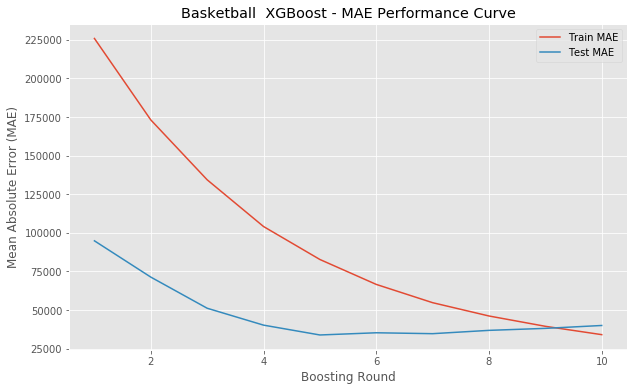

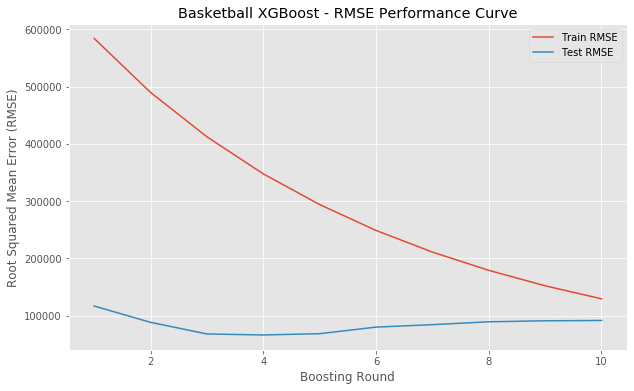

In [49]:

plot_performance_curves('Basketball', pre_evals_result_bb)

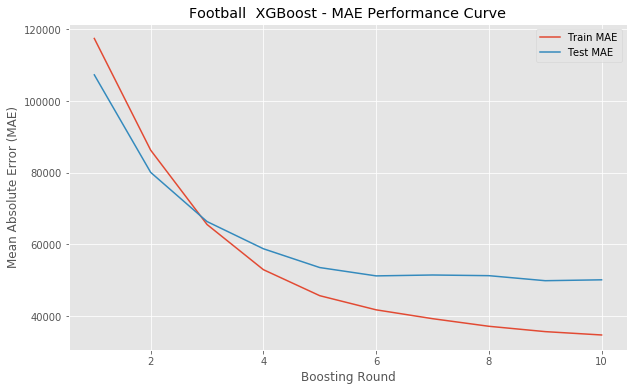

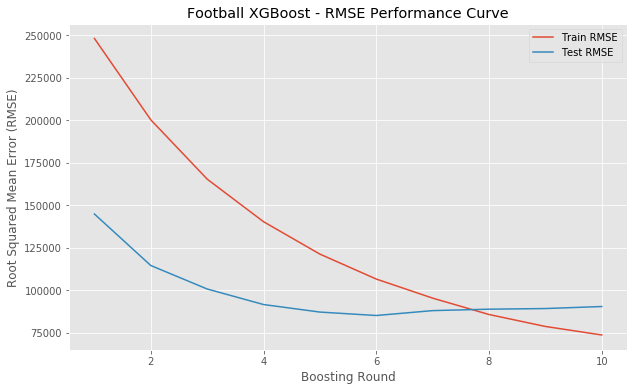

In [50]:
plot_performance_curves('Football', pre_evals_result_fb)

**What is feature importance of pre-tune models?**

In [51]:
Target = 'NILVAL_LONG_USD'
feature_name =['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN']

def plot_feature_importance(name, model, importance_type="weight"):
    # Obtain the feature importance scores
    importances = model.get_score(importance_type=importance_type)

    # Sort the features by importance in descending order
    sorted_feature_names = sorted(importances, key=importances.get, reverse=True)

    # Map sorted_feature_names to the corresponding feature names
    mapped_feature_names = [feature_name[sorted_feature_names.index(name)] for name in sorted_feature_names]

    # Create a feature importance plot with actual feature names as y-axis labels
    with plt.style.context("ggplot"):
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111)
        xgb.plotting.plot_importance(model, ax=ax, height=0.6, importance_type=importance_type)
        ax.set_yticklabels(mapped_feature_names)
        ax.set_title('XGBoost Regression  {} - Feature Importance'.format(name))
        plt.show()



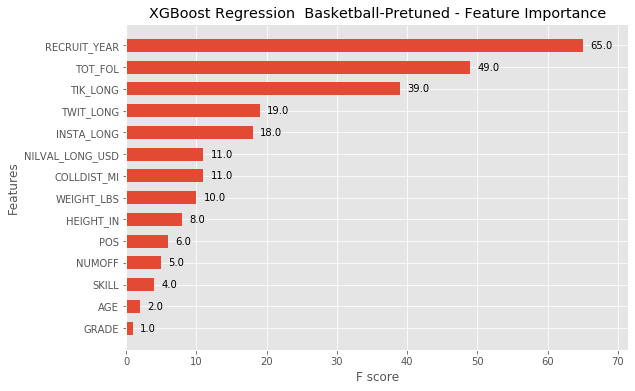

In [20]:

plot_feature_importance("Basketball-Pretuned", pretuned_model_bb, "weight")

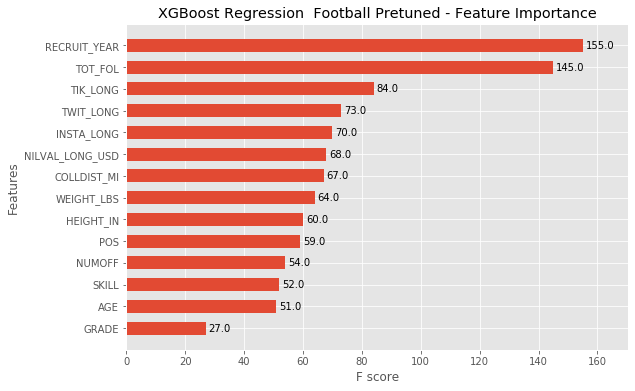

In [21]:

plot_feature_importance("Football Pretuned", pretuned_model_fb, "weight")

**K-Cross Fold Validation**
<br> Use built in xgb.cv() function- performed only on TRAIN set

In [52]:

def perform_k_fold_cross_validation(params, X_train, y_train, metrics, num_boost_round, early_stopping_rounds, num_folds=5):
    """
    Perform k-fold cross-validation for an XGBoost model.

    Parameters:
    - params: XGBoost hyperparameters
    - DM_train: DMatrix for the training data
    - metrics: List of evaluation metrics
    - num_boost_round: Number of boosting rounds
    - early_stopping_rounds: Early stopping criteria
    - num_folds: Number of cross-validation folds (default is 5)

    Returns:
    - cv_results: Cross-validation results as a pandas DataFrame
    """
    DM_train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical= True)

    cv_results = xgb.cv(
        params=params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        seed=42,  # Seed for randomization
        nfold=num_folds,
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds
    )
    return cv_results




Change eval metrics below as needed

In [23]:
# Define evaluation metrics (metrics)
metrics = {'rmse', 'mae'}
# Call the cross_validation function
cv_results_bb_pt = perform_k_fold_cross_validation(params, X_train_bb,y_train_bb, metrics, num_boost_round, early_stopping_rounds)
cv_results_fb_pt = perform_k_fold_cross_validation(params, X_train_fb,y_train_fb, metrics, num_boost_round, early_stopping_rounds)

In [53]:
def print_best_cv_results(name, cv_results):
    best_round = cv_results['test-rmse-mean'].idxmin()
    best_rmse = cv_results['test-rmse-mean'].min()
    best_mae = cv_results['test-mae-mean'][best_round]

    print("Best {} RMSE: {:.4f} at boosting round {}.".format(name, best_rmse, best_round))
    print("Best {} MAE: {:.4f} at boosting round {}.".format(name, best_mae, best_round))

In [54]:
#Pretuned cv results
print_best_cv_results('Basketball',cv_results_bb_pt)
print_best_cv_results('Football',cv_results_fb_pt)

Best Basketball RMSE: 397323.3504 at boosting round 77.
Best Basketball MAE: 138717.5705 at boosting round 77.
Best Football RMSE: 244371.3177 at boosting round 2.
Best Football MAE: 86131.5636 at boosting round 2.


In [55]:
def plot_learning_curves(name, cv_results):
    num_boost_rounds = len(cv_results)

    # Plot MAE learning curve
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_boost_rounds + 1), cv_results['train-mae-mean'], label='Train MAE')
    plt.plot(range(1, num_boost_rounds + 1), cv_results['test-mae-mean'], label='Test MAE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('MAE')
    plt.title('{} K Fold Learning Curve - MAE'.format(name))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot RMSE learning curve
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_boost_rounds + 1), cv_results['train-rmse-mean'], label='Train RMSE')
    plt.plot(range(1, num_boost_rounds + 1), cv_results['test-rmse-mean'], label='Test RMSE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title('{} K Fold Learning Curve - RMSE'.format(name))
    plt.legend()
    plt.grid(True)
    plt.show()



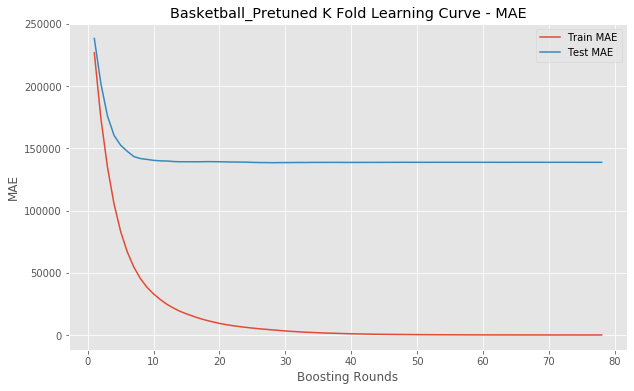

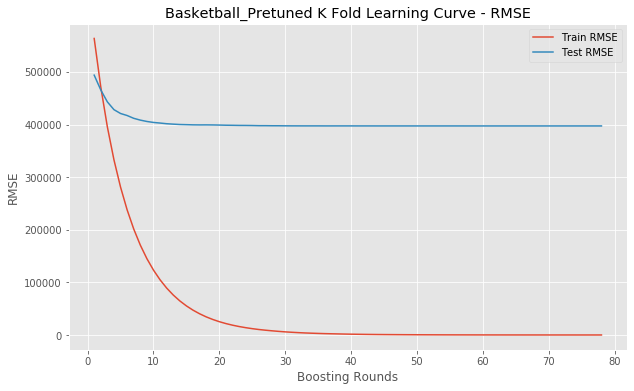

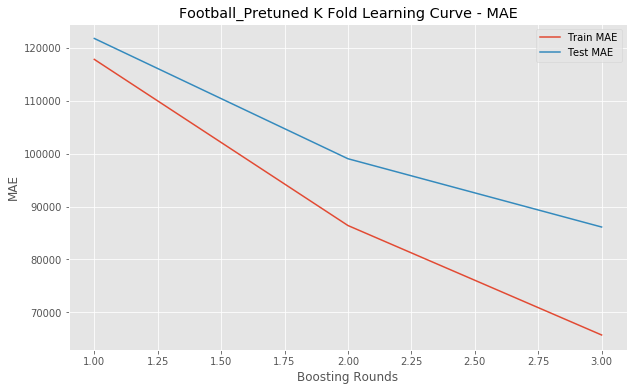

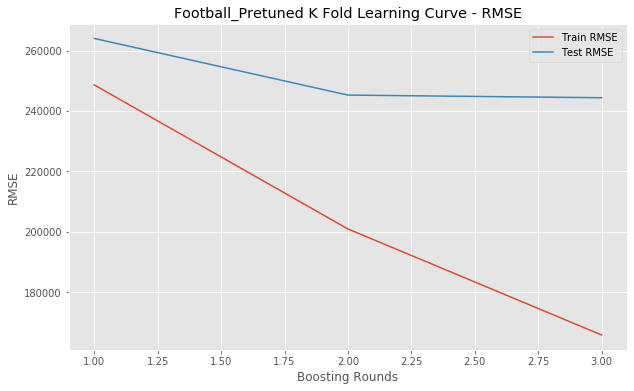

In [27]:

plot_learning_curves('Basketball_Pretuned',cv_results_bb_pt)
plot_learning_curves('Football_Pretuned',cv_results_fb_pt)




**Use GridSearchCV to find best parameters**

**GridSearch for all params above takes a long time- try pairwise grid search**

In [56]:
import itertools

def grid_search_hyperparameters(name, param_grid, parameter_sets, baseline_params, X_train, y_train, X_test, y_test):
    best_score = float('inf')
    best_params = baseline_params.copy()
    
    for param_set in parameter_sets:
        param1, param2 = param_set

        for val1, val2 in itertools.product(param_grid[param1], param_grid[param2]):
            # Create a copy of the current parameter settings
            params_copy = best_params.copy()

            # Set the values for the current pair of hyperparameters
            params_copy[param1] = val1
            params_copy[param2] = val2

            # Perform grid search using the current hyperparameters
            model, evals_result = bias_variance_performance(params_copy,X_train, y_train, X_test, y_test)  
            mae = min(evals_result['Test']['mae'])  # Use an appropriate metric

            # Check if this combination of hyperparameters is better
            if mae < best_score:
                best_score = mae
                best_params[param1] = val1
                best_params[param2] = val2

    return best_params, best_score


In [57]:
best_score = float('inf')  # Initialize with a high value
best_params = params.copy()  # Initialize with the baseline parameters

# Define hyperparameters and parameter grid
baseline_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'reg_alpha': 0.0,
    'reg_lambda': 1.0,
    'eval_metric': ['rmse', 'mae'],
    'objective': 'reg:squarederror',
    'tree_method': 'hist'
}

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0.1, 1, 10, 100],
     'eval_metric': ['rmse', 'mae'],
    # Other parameters-fixed
    'objective': ['reg:squarederror'],
    'tree_method': ['hist'],
    'verbosity': 1
}

# Define sets of hyperparameters to tune as pairs
parameter_sets = [
    ('max_depth', 'eta'),
    ('min_child_weight', 'gamma'),
    ('colsample_bytree', 'subsample'),
    ('reg_alpha', 'reg_lambda')
]

best_hyperparameters_bb, best_mae_bb = grid_search_hyperparameters('Basketball',param_grid, parameter_sets, baseline_params,X_train_bb, y_train_bb, X_test_bb, y_test_bb)

print("Best BB Hyperparameters:", best_hyperparameters_bb)
print("Best BB Score (MAE):", best_mae_bb)


[0]	Train-rmse:695619.03450	Train-mae:296286.30748	Test-rmse:168224.18149	Test-mae:138961.88988
[1]	Train-rmse:691801.83844	Train-mae:293785.14062	Test-rmse:166469.41937	Test-mae:137368.45536
[2]	Train-rmse:688009.92274	Train-mae:291313.54219	Test-rmse:164621.33505	Test-mae:135725.12184
[3]	Train-rmse:684243.29661	Train-mae:288856.73832	Test-rmse:162903.02504	Test-mae:134162.80655
[4]	Train-rmse:680501.43467	Train-mae:286428.99165	Test-rmse:161092.59581	Test-mae:132551.20052
[5]	Train-rmse:676784.54046	Train-mae:284015.74346	Test-rmse:159410.13038	Test-mae:131019.40960
[6]	Train-rmse:673091.89405	Train-mae:281631.04655	Test-rmse:157636.72754	Test-mae:129438.92597
[7]	Train-rmse:669423.84513	Train-mae:279267.53914	Test-rmse:155881.84869	Test-mae:127873.75781
[8]	Train-rmse:665779.77660	Train-mae:276918.06579	Test-rmse:154252.04984	Test-mae:126386.80729
[9]	Train-rmse:662159.84421	Train-mae:274596.43516	Test-rmse:152533.27086	Test-mae:124851.86421
Best MAE : 124851.8642 with 10 rounds
Be

[7]	Train-rmse:453050.91574	Train-mae:151799.15395	Test-rmse:74133.21044	Test-mae:53049.21057
[8]	Train-rmse:430185.95242	Train-mae:142180.99671	Test-rmse:72479.22560	Test-mae:50995.90923
[9]	Train-rmse:408202.24783	Train-mae:133056.83660	Test-rmse:67441.78376	Test-mae:46844.66146
Best MAE : 46844.6615 with 10 rounds
Best RMSE : 67441.7838 with 10 rounds
[0]	Train-rmse:623117.34911	Train-mae:248335.67270	Test-rmse:134849.14019	Test-mae:108390.17708
[1]	Train-rmse:556693.72989	Train-mae:207132.15041	Test-rmse:106890.26186	Test-mae:79554.00316
[2]	Train-rmse:498215.88412	Train-mae:174511.48183	Test-rmse:86575.68706	Test-mae:60171.52251
[3]	Train-rmse:447043.05154	Train-mae:148642.74260	Test-rmse:75371.66968	Test-mae:53373.63690
[4]	Train-rmse:402154.48485	Train-mae:132108.98602	Test-rmse:74349.68469	Test-mae:52264.24628
[5]	Train-rmse:361402.42204	Train-mae:117513.30699	Test-rmse:68864.78420	Test-mae:50215.65699
[6]	Train-rmse:325897.48838	Train-mae:103948.72911	Test-rmse:70298.21701	Tes

In [30]:
print("Parameters after the Pair Wise Tuning")
best_hyperparameters_bb

Parameters after the Pair Wise Tuning


{'max_depth': 7,
 'min_child_weight': 1,
 'eta': 0.01,
 'subsample': 0.8,
 'colsample_bytree': 1.0,
 'gamma': 0.0,
 'reg_alpha': 0.3,
 'reg_lambda': 0.1,
 'eval_metric': ['rmse', 'mae'],
 'objective': 'reg:squarederror',
 'tree_method': 'hist'}

In [58]:
#FOOTBALLL
best_score = float('inf')  # Initialize with a high value
best_params = params.copy()  # Initialize with the baseline parameters

# Define hyperparameters and parameter grid
baseline_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'reg_alpha': 0.0,
    'reg_lambda': 1.0,
    'eval_metric': ['rmse', 'mae'],
    'objective': 'reg:squarederror',
    'tree_method': 'hist'
}

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0.1, 1, 10, 100],
    'eval_metric': ['rmse', 'mae'],
    # Other parameters-fixed
    'objective': ['reg:squarederror'],
    'tree_method': ['hist'],
    'verbosity': 1
}

# Define sets of hyperparameters to tune as pairs
parameter_sets = [
    ('max_depth', 'eta'),
    ('min_child_weight', 'gamma'),
    ('colsample_bytree', 'subsample'),
    ('reg_alpha', 'reg_lambda')
]

best_hyperparameters_fb, best_mae_fb = grid_search_hyperparameters('Football',param_grid, parameter_sets, baseline_params,X_train_fb, y_train_fb, X_test_fb, y_test_fb)

print("Best FB Hyperparameters:", best_hyperparameters_fb)
print("Best FB Score (MAE):", best_mae_fb)


[0]	Train-rmse:312305.10299	Train-mae:161521.38929	Test-rmse:198409.75390	Test-mae:147154.24258
[1]	Train-rmse:310196.97580	Train-mae:159955.73507	Test-rmse:196272.30889	Test-mae:145624.03466
[2]	Train-rmse:308111.45774	Train-mae:158405.33330	Test-rmse:194161.74066	Test-mae:144108.73255
[3]	Train-rmse:306048.37065	Train-mae:156870.03202	Test-rmse:192077.94070	Test-mae:142608.19252
[4]	Train-rmse:304007.51449	Train-mae:155349.68499	Test-rmse:190020.78831	Test-mae:141122.26626
[5]	Train-rmse:301988.70105	Train-mae:153844.15145	Test-rmse:187990.18857	Test-mae:139650.81850
[6]	Train-rmse:299991.73717	Train-mae:152353.27692	Test-rmse:185986.02373	Test-mae:138193.69934
[7]	Train-rmse:298016.43768	Train-mae:150876.92326	Test-rmse:184008.19984	Test-mae:136750.77177
[8]	Train-rmse:296057.34554	Train-mae:149416.57707	Test-rmse:182077.97411	Test-mae:135321.04461
[9]	Train-rmse:294123.68213	Train-mae:147968.83992	Test-rmse:180151.17248	Test-mae:133906.20350
Best MAE : 133906.2035 with 10 rounds
Be

[4]	Train-rmse:229127.77554	Train-mae:99340.96180	Test-rmse:121617.93722	Test-mae:85913.72315
[5]	Train-rmse:217203.08395	Train-mae:90836.33201	Test-rmse:113767.09588	Test-mae:77890.26098
[6]	Train-rmse:206601.63494	Train-mae:83524.49020	Test-rmse:107496.18025	Test-mae:70527.06879
[7]	Train-rmse:197026.47729	Train-mae:77878.29096	Test-rmse:102986.65479	Test-mae:65942.10555
[8]	Train-rmse:188509.45550	Train-mae:73247.68008	Test-rmse:98384.39691	Test-mae:62567.59285
[9]	Train-rmse:180807.32646	Train-mae:69832.91879	Test-rmse:96077.59788	Test-mae:60101.26706
Best MAE : 60101.2671 with 10 rounds
Best RMSE : 96077.5979 with 10 rounds
[0]	Train-rmse:272737.95377	Train-mae:131481.35465	Test-rmse:159062.84159	Test-mae:117794.30697
[1]	Train-rmse:239710.69621	Train-mae:106644.68099	Test-rmse:129695.91218	Test-mae:93199.10000
[2]	Train-rmse:214106.36958	Train-mae:88952.20761	Test-rmse:111234.99577	Test-mae:75108.99940
[3]	Train-rmse:193875.71289	Train-mae:75911.57493	Test-rmse:102918.88195	Test-

In [59]:
#FOOTBALL
print("Parameters after the Pair Wise Tuning")
best_hyperparameters_fb

Parameters after the Pair Wise Tuning


{'max_depth': 6,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'gamma': 0.0,
 'reg_alpha': 0.2,
 'reg_lambda': 1,
 'eval_metric': ['rmse', 'mae'],
 'objective': 'reg:squarederror',
 'tree_method': 'hist'}

**NOW RUN TUNED HYPERPARAMETERS FOR BB and FB XGBOOST MODEL**

In [60]:
#Now run tuned hyperparmeters (best_params) 
# num_boost_rounds = 1000
# early_stopping_rounds = 94

#basketball
pw_bb_model, pwbb_evals_result = bias_variance_performance(best_hyperparameters_bb, X_train_bb, y_train_bb, X_test_bb, y_test_bb)

[0]	Train-rmse:622170.69662	Train-mae:250153.76464	Test-rmse:134323.17531	Test-mae:108663.86756
[1]	Train-rmse:554725.30672	Train-mae:210365.87936	Test-rmse:101337.13697	Test-mae:84100.55655
[2]	Train-rmse:495312.52083	Train-mae:178036.00103	Test-rmse:83133.97446	Test-mae:68307.49740
[3]	Train-rmse:442878.11067	Train-mae:151380.45925	Test-rmse:70852.06147	Test-mae:56682.32143
[4]	Train-rmse:396391.37575	Train-mae:128672.57829	Test-rmse:62582.00664	Test-mae:46108.14062
[5]	Train-rmse:354852.64437	Train-mae:109555.75345	Test-rmse:63693.20152	Test-mae:39660.87872
[6]	Train-rmse:318159.91535	Train-mae:94027.25317	Test-rmse:62830.11011	Test-mae:34079.00688
[7]	Train-rmse:285306.33323	Train-mae:80912.49687	Test-rmse:69839.18980	Test-mae:32951.83222
[8]	Train-rmse:256177.36687	Train-mae:70158.41711	Test-rmse:71687.02125	Test-mae:31763.74368
[9]	Train-rmse:230144.81799	Train-mae:61291.49030	Test-rmse:73709.33470	Test-mae:31156.22247
Best MAE : 31156.2225 with 10 rounds
Best RMSE : 62582.0066 w

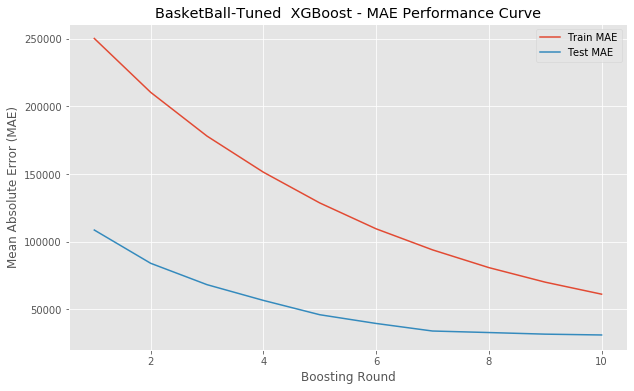

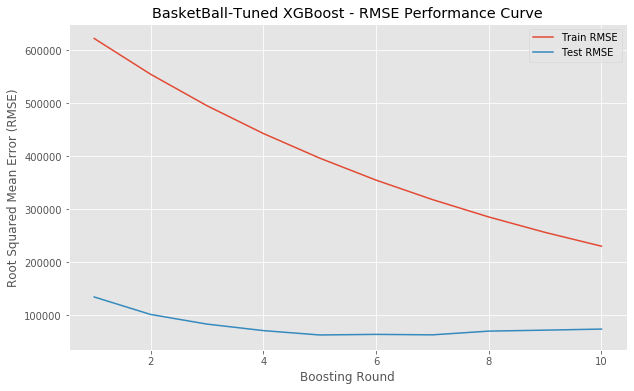

In [61]:
#plot tuned perforamnce curve
plot_performance_curves('BasketBall-Tuned',pwbb_evals_result )

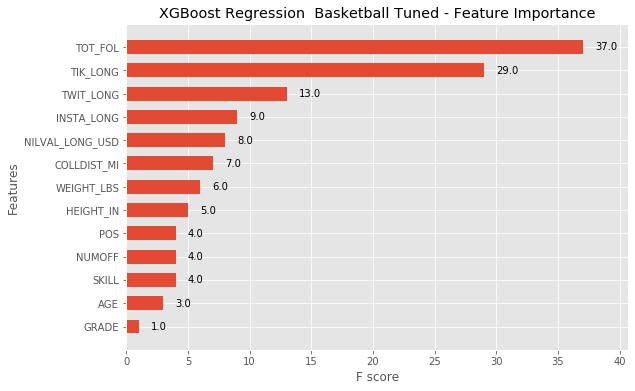

In [62]:
#plot tuned feature importance

plot_feature_importance("Basketball Tuned", pw_bb_model, "weight")

In [63]:
#football
pw_fb_model, pwfb_evals_result = bias_variance_performance(best_hyperparameters_fb, X_train_fb, y_train_fb, X_test_fb, y_test_fb)

[0]	Train-rmse:250894.59945	Train-mae:118161.15284	Test-rmse:145262.43164	Test-mae:106235.28314
[1]	Train-rmse:218408.85157	Train-mae:88582.89898	Test-rmse:122435.15659	Test-mae:81647.48004
[2]	Train-rmse:183871.93395	Train-mae:68537.44682	Test-rmse:108141.08155	Test-mae:66414.15140
[3]	Train-rmse:156687.52347	Train-mae:57129.61429	Test-rmse:101787.52486	Test-mae:60051.68614
[4]	Train-rmse:135146.14393	Train-mae:49697.86446	Test-rmse:88121.28253	Test-mae:53000.70251
[5]	Train-rmse:118198.96413	Train-mae:45113.86008	Test-rmse:84487.45916	Test-mae:50808.09959
[6]	Train-rmse:103945.01783	Train-mae:41609.22381	Test-rmse:83642.91837	Test-mae:50606.53117
[7]	Train-rmse:96982.58739	Train-mae:38686.74938	Test-rmse:81685.22528	Test-mae:49329.19844
[8]	Train-rmse:87960.10943	Train-mae:37025.33493	Test-rmse:81505.35944	Test-mae:49446.57484
[9]	Train-rmse:80566.48184	Train-mae:35191.83620	Test-rmse:82317.44669	Test-mae:49000.21546
Best MAE : 49000.2155 with 10 rounds
Best RMSE : 81505.3594 with 9 

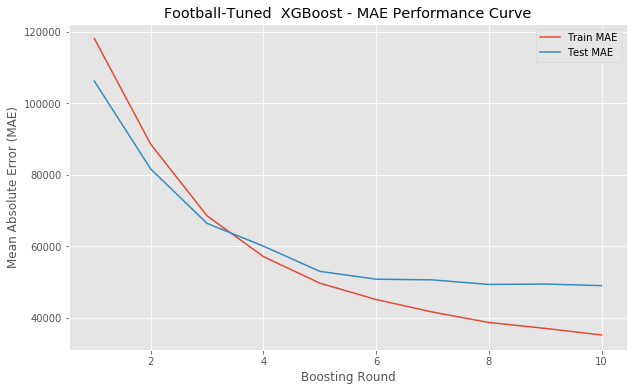

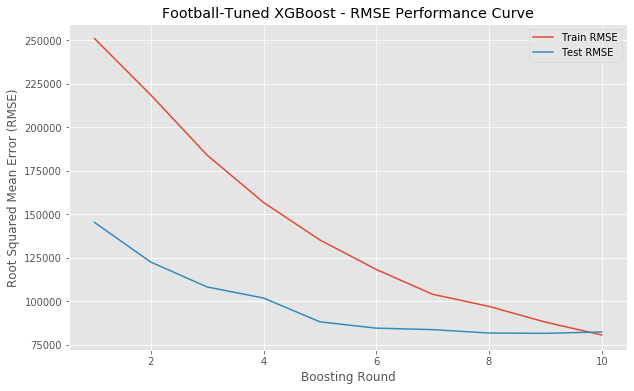

In [64]:
#plot tuned perforamnce curve
plot_performance_curves('Football-Tuned',pwfb_evals_result )

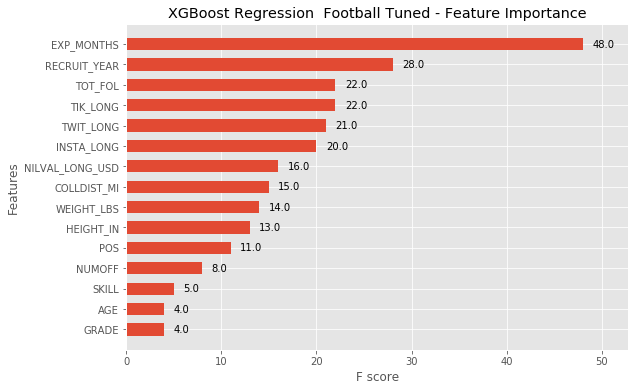

In [65]:
#plot tuned feature importance

plot_feature_importance("Football Tuned", pw_fb_model, "weight")

In [66]:
cv_results_bb_pw = perform_k_fold_cross_validation(best_hyperparameters_bb, X_train_bb,y_train_bb, metrics, num_boost_round, early_stopping_rounds)
cv_results_fb_pw = perform_k_fold_cross_validation(best_hyperparameters_fb, X_train_fb,y_train_fb, metrics, num_boost_round, early_stopping_rounds)


print_best_cv_results('Basketball Pretuned',cv_results_bb_pt)
print_best_cv_results('Basketball Tuned',cv_results_bb_pw)
print_best_cv_results('Football Pretuned',cv_results_fb_pt)
print_best_cv_results('Football Tune',cv_results_fb_pw)

Best Basketball Pretuned RMSE: 397323.3504 at boosting round 77.
Best Basketball Pretuned MAE: 138717.5705 at boosting round 77.
Best Basketball Tuned RMSE: 420267.8622 at boosting round 9.
Best Basketball Tuned MAE: 150110.2917 at boosting round 9.
Best Football Pretuned RMSE: 244371.3177 at boosting round 2.
Best Football Pretuned MAE: 86131.5636 at boosting round 2.
Best Football Tune RMSE: 219227.7201 at boosting round 4.
Best Football Tune MAE: 74616.5844 at boosting round 4.


**Evaluation** During boosting rounds, the model object has learned all the patterns of the training set. Perform testing.

In [40]:
from sklearn.model_selection import KFold

In [41]:


def train_xgboost_with_cv_and_analysis(X_train, y_train, X_test, y_test, params, num_boost_round, early_stopping_rounds):
    # Define the number of folds for cross-validation
    n_folds = 5  # You can adjust this as needed
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize XGBoost model with the given parameters
    model = xgb.XGBRegressor(**params)
    
    # Create a list to store cross-validation scores
    cv_scores = []
    
    # Create a list to store feature importances
    feature_importances = []
    shap_values_list = []  # List to store SHAP values for each fold
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Train the model with early stopping by setting parameters during initialization
        model.set_params(early_stopping_rounds=early_stopping_rounds)
        eval_results = {}
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
        )
        
        # Make predictions on the test set using iteration_range instead of ntree_limit
        y_pred = model.predict(X_test, iteration_range=(0, model.best_iteration))
        
        # Calculate the MAE for this fold
        fold_mae = mean_absolute_error(y_test, y_pred)
        cv_scores.append(fold_mae)
        
      #Explain the model's predictions using SHAP
        explainer = shap.Explainer(model)
        
        # Handle feature selection if X_test has fewer features
        if X_test.shape[1] < X_train.shape[1]:
            # Select only the relevant features from X_train
            selected_features = X_train.columns[:X_test.shape[1]]
            X_test_subset = X_test[selected_features]
            shap_values = explainer.shap_values(X_test_subset)
        else:
            shap_values = explainer.shap_values(X_test)
        
        shap_values_list.append(shap_values)
        
        # Calculate and store feature importances for this fold
        fold_feature_importances = np.abs(shap_values).mean(axis=0)
        feature_importances.append(fold_feature_importances)
    
    # Calculate the average feature importance across all folds
    average_feature_importance = np.mean(feature_importances, axis=0)
    
    # Calculate the mean cross-validation MAE
    mean_cv_mae = np.mean(cv_scores)
    
    # Concatenate the list of SHAP values into a matrix
    shap_values_matrix = np.vstack(shap_values_list)
    
    return model, mean_cv_mae, average_feature_importance, shap_values_matrix

# 

In [42]:

# Example usage:
params = {
    'max_depth': 7,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'reg_alpha': 0.0,
    'reg_lambda': 1.0,
    'eval_metric': 'mae',  # Use MAE for evaluation
    'objective': 'reg:squarederror',
    'tree_method': 'hist'
}

num_boost_round = 1000
early_stopping_rounds = 20

model, mean_cv_mae, feature_importance, shap_values_matrix = train_xgboost_with_cv_and_analysis(
    X_train_bb, y_train_bb, X_test_bb, y_test_bb, params, num_boost_round, early_stopping_rounds
)

print("Mean Cross-Validation MAE:", mean_cv_mae)


[0]	validation_0-mae:200605.89309
[1]	validation_0-mae:164828.49219
[2]	validation_0-mae:132344.19881
[3]	validation_0-mae:114481.86554
[4]	validation_0-mae:105796.20518
[5]	validation_0-mae:103326.87541
[6]	validation_0-mae:97271.38692
[7]	validation_0-mae:91317.91859
[8]	validation_0-mae:88278.21957
[9]	validation_0-mae:85123.39062
[10]	validation_0-mae:83230.41036
[11]	validation_0-mae:82061.38446
[12]	validation_0-mae:81327.04975
[13]	validation_0-mae:81259.76974
[14]	validation_0-mae:81264.81949
[15]	validation_0-mae:81088.52344
[16]	validation_0-mae:81021.71176
[17]	validation_0-mae:80293.30345
[18]	validation_0-mae:80087.26480
[19]	validation_0-mae:79812.95518
[20]	validation_0-mae:80087.24959
[21]	validation_0-mae:80215.75576
[22]	validation_0-mae:80029.39967
[23]	validation_0-mae:79801.20395
[24]	validation_0-mae:79894.10855
[25]	validation_0-mae:79773.14844
[26]	validation_0-mae:79688.01974
[27]	validation_0-mae:79675.22862
[28]	validation_0-mae:79722.79646
[29]	validation_0-

[0]	validation_0-mae:448803.71937
[1]	validation_0-mae:405922.59745
[2]	validation_0-mae:376970.22985
[3]	validation_0-mae:359487.95847
[4]	validation_0-mae:344220.50000
[5]	validation_0-mae:334706.57422
[6]	validation_0-mae:331293.30078
[7]	validation_0-mae:328552.99671
[8]	validation_0-mae:326970.71402
[9]	validation_0-mae:325706.85403
[10]	validation_0-mae:324079.21423
[11]	validation_0-mae:323444.99054
[12]	validation_0-mae:322521.98602
[13]	validation_0-mae:321265.06949
[14]	validation_0-mae:320080.01974
[15]	validation_0-mae:319615.65543
[16]	validation_0-mae:319273.14268
[17]	validation_0-mae:318685.83429
[18]	validation_0-mae:318504.70189
[19]	validation_0-mae:318195.87212
[20]	validation_0-mae:317638.54276
[21]	validation_0-mae:317355.18997
[22]	validation_0-mae:317450.46546
[23]	validation_0-mae:317477.31291
[24]	validation_0-mae:317228.78865
[25]	validation_0-mae:317090.13076
[26]	validation_0-mae:316915.21957
[27]	validation_0-mae:316728.16530
[28]	validation_0-mae:316634.4

In [43]:
X_test_bb.shape
X_train_bb.shape

(95, 17)

IndexError: index 79 is out of bounds for axis 0 with size 21

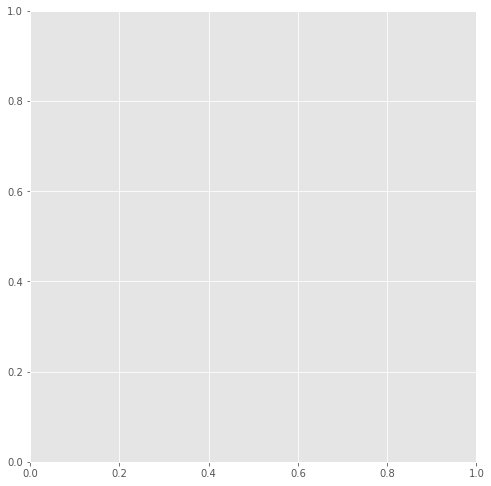

In [67]:

# Generate a summary plot with the matrix of SHAP values
shap.summary_plot(shap_values_matrix, X_test_bb)

**Feature Ablation**


In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

In [ ]:


# dataset in X (a pandas DataFrame) and y
# Create a DMatrix for the original dataset
dtest = xgb.DMatrix(X_test_bb, label=y_test_bb)

# Get the initial performance of the pre-trained model
initial_performance = roc_auc_score(y, pw_bb_model.predict(dtest))

feature_importance = {}

for col in X.columns:  # Assuming X is a pandas DataFrame
    # Create a copy of the dataset with the current feature removed
    reduced_X = X.drop(columns=[col])
    
    # Create a DMatrix for the reduced dataset
    dtest_reduced = xgb.DMatrix(reduced_X, label=y)
    
    # Get predictions from the pre-trained model on the reduced dataset
    predictions = pw_bb_model.predict(dtest_reduced)
    
    # Evaluate the performance of the model with the feature removed
    # You can use the same evaluation metric as in the initial model
    performance_metric = roc_auc_score(y, predictions)
    
    # Calculate the drop in performance due to feature removal
    feature_importance[col] = initial_performance - performance_metric

# Sort and print feature importance
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")
